In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

### Test data x^3 + a x^2       a: [-1,3]

In [214]:
labels = np.linspace(-3,3,1000)
corr_labels = np.tile(labels, (6, 1)).T
# print(corr_labels[:,0])
x = np.linspace(-2,2,6)
corr_data = np.zeros((1000,6))
for i in range(len(corr_data)):
    corr_data[i] = x**3 - corr_labels[i,0]*x**2
# plt.plot(corr_data[100])
# plt.plot(corr_data[800])
corr_data += 5*np.random.uniform(-1,1, size=corr_data.shape)
# plt.plot(corr_data[100])
# plt.plot(corr_data[800])

## Proxy Correlation data

In [259]:
label_table = np.loadtxt("CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt", skiprows=1, usecols=range(1, 7))

# d = np.load("../wgplus_data.npz")
d = np.load("../wgcross_data.npz")
# dictionary
axes = ['x', 'y', 'z']
r = d['r']
wgplusses = {axis: d[axis] for axis in axes}
d = np.load("../wgg_data.npz")
wgg = d['wgg']

# Example: Access the 250th row, 4th column of the 'x' axis
print(label_table.shape)
print(wgplusses['x'].shape)
corr_data = np.array(wgplusses['x'])
corr_data = np.append(corr_data, np.append(wgplusses['y'],wgplusses['z'],axis=0),axis=0)
corr_labels = np.repeat(label_table, 3, axis=0)
corr_data = wgg
print(corr_data.shape, corr_labels.shape)

(1000, 6)
(1000, 6)
(3000, 6) (3000, 6)


### ML Process with corr_data and corr_labels

In [260]:
# shuffle
num_samples = corr_data.shape[0]
random_indices = np.random.permutation(num_samples)
corr_data = corr_data[random_indices]
corr_labels = corr_labels[random_indices]

In [261]:
# Normalise
mean_labels = np.mean(corr_labels,axis=0)
std_labels = np.std(corr_labels,axis=0)
print(mean_labels)
print(std_labels)
renorm_labels = (corr_labels-mean_labels) / (std_labels)  #+ 0.5 # mean of 0.5, std of 0.2

mean_corrs = np.mean(corr_data,axis=0)
std_corrs = np.std(corr_data,axis=0)
print(mean_corrs)
print(std_corrs)
renorm_corrs = (corr_data-mean_corrs)/(std_corrs)  # mean of 0, std of 0.2

[0.3        0.8        1.35252612 1.35252612 1.08202118 1.08202118]
[0.11547    0.11547    1.02214894 1.02214894 0.42632871 0.42632871]
[51.91713986 22.6330237   9.79580723  3.1417634  -0.33161654 -0.4740996 ]
[33.03690755 13.30980841  5.37435625  2.69457017  1.90230346  1.94091937]


Text(0, 0.5, 'Frequency')

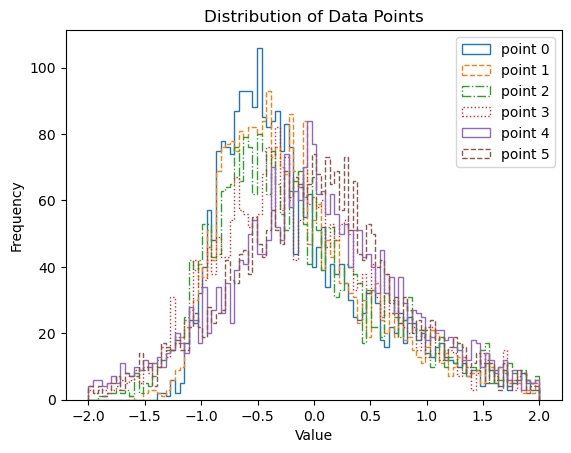

In [262]:
from cycler import cycle
lines = ["-","--","-.",":"]
linecycler = cycle(lines)
for i in [0,1,2,3,4,5]:
    plt.hist(renorm_corrs[:,i], bins=np.linspace(-2,2,100),histtype=u'step', label=f'point {i}',linestyle=next(linecycler))
plt.legend()
plt.title(f'Distribution of Data Points')
plt.xlabel('Value')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

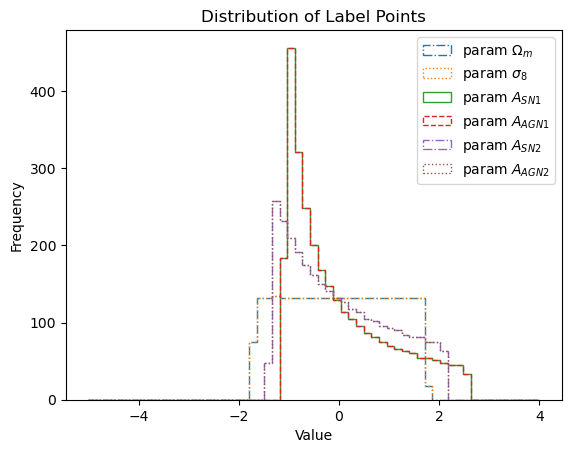

In [263]:
simpars = ['\Omega_m','\sigma_8','A_{SN1}','A_{AGN1}','A_{SN2}','A_{AGN2}']
for i in range(6):
    plt.hist(renorm_labels[:,i], bins=np.linspace(-5,4,60), histtype=u'step', label=f'param ${simpars[i]}$',linestyle=next(linecycler))
plt.legend()
plt.title(f'Distribution of Label Points')
plt.xlabel('Value')
plt.ylabel('Frequency')

In [264]:
train_data, test_data, train_label, test_label = train_test_split(renorm_corrs, renorm_labels, test_size = 0.1, random_state = None, shuffle=True)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.05, random_state = None)
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)
print(val_data.shape, val_label.shape)

(2565, 6) (2565, 6)
(300, 6) (300, 6)
(135, 6) (135, 6)


#### Build Model

In [265]:
model = keras.models.Sequential()
#model.add(normalizer)
model.add(tf.keras.layers.Dense(128, input_shape=(6,), activation="relu"))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(64, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(32, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(8, activation='relu'))


# model.add(tf.keras.layers.BatchNormalization())  # Normalization 3
model.add(tf.keras.layers.Dense(1, activation='tanh'))
#model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.build()
model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_216 (Dense)           (None, 128)               896       
                                                                 
 dense_217 (Dense)           (None, 64)                8256      
                                                                 
 dense_218 (Dense)           (None, 32)                2080      
                                                                 
 dense_219 (Dense)           (None, 8)                 264       
                                                                 
 dense_220 (Dense)           (None, 1)                 9         
                                                                 
Total params: 11505 (44.94 KB)
Trainable params: 11505 (44.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


10/10 [==============================] - 0s 418us/step
End validation loss is: 1.0630924701690674


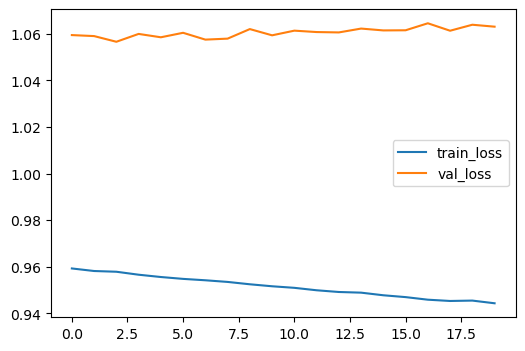

In [268]:
param=1
pre_test_predict=model.predict(test_data, verbose=1)
history=model.fit(train_data,train_label[:,param],epochs=20,batch_size=100,verbose=0,validation_data=(val_data,val_label[:,param]))

print("End validation loss is:", history.history['val_loss'][-1])
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

10/10 [==============================] - 0s 353us/step


Text(0.5, 1.0, 'Testing Data')

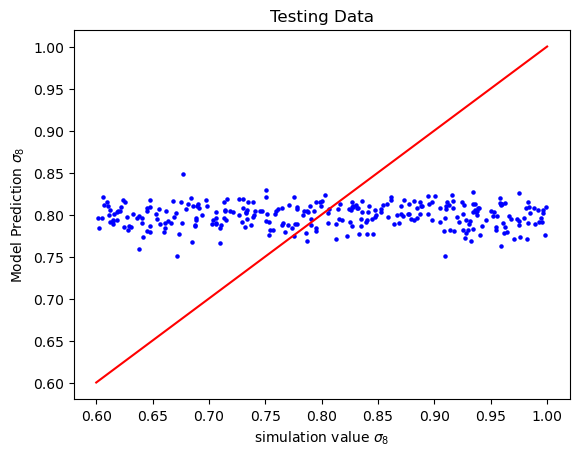

In [269]:
simpars = ['\Omega_m','\sigma_8','A_{SN1}','A_{AGN1}','A_{SN2}','A_{AGN2}']
lims = [[0.1,0.5],[0.6,1.0],[0.25,4.0],[0.25,4.0],[0.5,2.0],[0.5,2.0]]
test_predict=model.predict(test_data, verbose=1)
test_predict = test_predict*std_labels[param] + mean_labels[param]
test_label_unorm = test_label[:,param]*std_labels[param] + mean_labels[param]
plt.plot(lims[param],lims[param],c='r')
plt.scatter(test_label_unorm, test_predict,s=5, color='blue')
# plt.ylim([np.min(test_label[:,param]),np.max(test_label[:,param])])
# plt.xlim([np.min(test_label[:,param]),np.max(test_label[:,param])])
plt.ylabel(f'Model Prediction ${simpars[param]}$')
plt.xlabel(f'simulation value ${simpars[param]}$')
plt.title('Testing Data')
# plt.axhline(0.5,c='k')

## DM corr data

In [157]:
wgplussesDM_z = []
wgcrossesDM_z = []
ggsDM_z = []
for i in range(0,700):
    for j, f in enumerate((f'../correlatingDM-folder/OUTPUT_CAMELS_DM_LH_z/wgp_LH{i}.dat',f'../correlatingDM-folder/OUTPUT_CAMELS_DM_LH_z/wgg_LH{i}.dat')):
        dat = ascii.read(f)
        if j == 0:
#             print(dat.colnames)
#             print(dat['meanr'])
            r, wgp, wgx = dat['rnom'], dat['wgplus'], dat['wgcross']
        elif j == 1:
            r, wgg = dat['rnom'], dat['wgg']
    
    wgplussesDM_z.append(wgp)
    wgcrossesDM_z.append(wgx)
    ggsDM_z.append(wgg)
    
label_table = np.loadtxt("CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt", skiprows=1, usecols=range(1, 7))
corr_labels = label_table[:700]
print(corr_labels.shape)

(700, 6)


In [158]:
corr_data = np.array(ggsDM_z)

In [159]:
# shuffle
num_samples = corr_data.shape[0]
random_indices = np.random.permutation(num_samples)
corr_data = corr_data[random_indices]
corr_labels = corr_labels[random_indices]
# Normalise
mean_labels = np.mean(corr_labels,axis=0)
std_labels = np.std(corr_labels,axis=0)
print(mean_labels)
print(std_labels)
renorm_labels = (corr_labels-mean_labels) / (std_labels)  #+ 0.5 # mean of 0.5, std of 0.2

mean_corrs = np.mean(corr_data,axis=0)
std_corrs = np.std(corr_data,axis=0)
print(mean_corrs)
print(std_corrs)
renorm_corrs = (corr_data-mean_corrs)/(std_corrs)  # mean of 0, std of 0.2

[0.29849143 0.80156743 1.34326033 1.3370337  1.09084681 1.08025094]
[0.11531638 0.11458019 1.03403915 1.01497173 0.43112156 0.42591877]
[46.90049885 20.20083629  8.77645191  2.70754869 -0.74149256 -0.98322636]
[33.06937866 13.06709321  5.13598659  2.35713872  1.58342893  1.66363847]


In [160]:
train_data, test_data, train_label, test_label = train_test_split(renorm_corrs, renorm_labels, test_size = 0.1, random_state = None, shuffle=True)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.05, random_state = None)
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)
print(val_data.shape, val_label.shape)

(598, 6) (598, 6)
(70, 6) (70, 6)
(32, 6) (32, 6)


#### Build Model

In [161]:
model = keras.models.Sequential()
#model.add(normalizer)
model.add(tf.keras.layers.Dense(128, input_shape=(6,), activation="relu"))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(64, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(64, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(8, activation='relu'))


# model.add(tf.keras.layers.BatchNormalization())  # Normalization 3
model.add(tf.keras.layers.Dense(1, activation='tanh'))
#model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.build()
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_189 (Dense)           (None, 128)               896       
                                                                 
 dense_190 (Dense)           (None, 64)                8256      
                                                                 
 dense_191 (Dense)           (None, 64)                4160      
                                                                 
 dense_192 (Dense)           (None, 8)                 520       
                                                                 
 dense_193 (Dense)           (None, 1)                 9         
                                                                 
Total params: 13841 (54.07 KB)
Trainable params: 13841 (54.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


3/3 [==============================] - 0s 835us/step
End validation loss is: 0.760236918926239


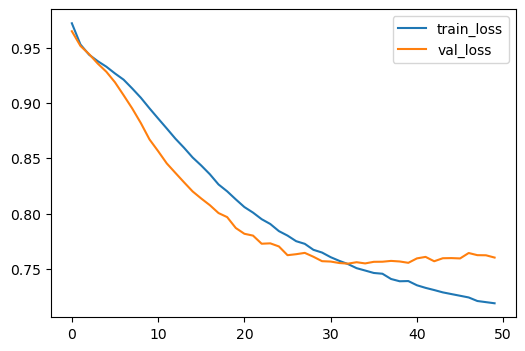

In [162]:
param=1
pre_test_predict=model.predict(test_data, verbose=1)
history=model.fit(train_data,train_label[:,param],epochs=50,batch_size=32,verbose=0,validation_data=(val_data,val_label[:,param]))

print("End validation loss is:", history.history['val_loss'][-1])
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

3/3 [==============================] - 0s 685us/step


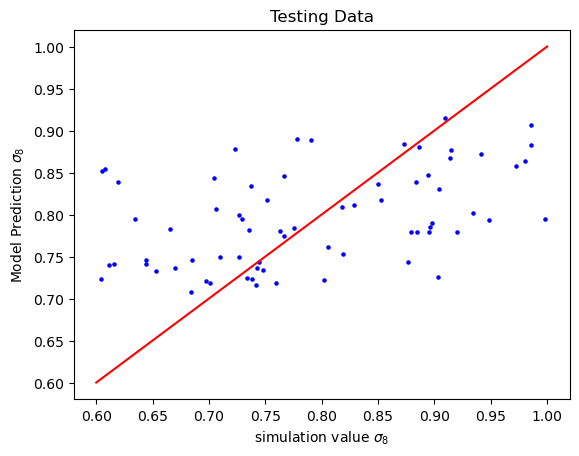

In [164]:
simpars = ['\Omega_m','\sigma_8','A_{SN1}','A_{AGN1}','A_{SN2}','A_{AGN2}']
lims = [[0.1,0.5],[0.6,1.0],[0.25,4.0],[0.25,4.0],[0.5,2.0],[0.5,2.0]]
test_predict=model.predict(test_data, verbose=1)
test_predict = test_predict*std_labels[param] + mean_labels[param]
test_label_unorm = test_label[:,param]*std_labels[param] + mean_labels[param]
plt.plot(lims[param],lims[param],c='r')
plt.scatter(test_label_unorm, test_predict,s=5, color='blue')
# plt.ylim([np.min(test_label[:,param]),np.max(test_label[:,param])])
# plt.xlim([np.min(test_label[:,param]),np.max(test_label[:,param])])
plt.ylabel(f'Model Prediction ${simpars[param]}$')
plt.xlabel(f'simulation value ${simpars[param]}$')
plt.title('Testing Data')
# plt.axhline(0.5,c='k')
#save
raw_sig8 = test_label_unorm 
raw_sig8_pred = test_predict 

### All Params at once

In [122]:
wgplussesDM_z = []
wgcrossesDM_z = []
ggsDM_z = []
for i in range(0,700):
    for j, f in enumerate((f'../correlatingDM-folder/OUTPUT_CAMELS_DM_LH_z/wgp_LH{i}.dat',f'../correlatingDM-folder/OUTPUT_CAMELS_DM_LH_z/wgg_LH{i}.dat')):
        dat = ascii.read(f)
        if j == 0:
#             print(dat.colnames)
#             print(dat['meanr'])
            r, wgp, wgx = dat['rnom'], dat['wgplus'], dat['wgcross']
        elif j == 1:
            r, wgg = dat['rnom'], dat['wgg']
    
    wgplussesDM_z.append(wgp)
    wgcrossesDM_z.append(wgx)
    ggsDM_z.append(wgg)
    
label_table = np.loadtxt("CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt", skiprows=1, usecols=range(1, 7))
corr_labels = label_table[:700]
print(corr_labels.shape)

(700, 6)


In [123]:
corr_data = np.array(wgplussesDM_z)

In [124]:
# shuffle
num_samples = corr_data.shape[0]
random_indices = np.random.permutation(num_samples)
corr_data = corr_data[random_indices]
corr_labels = corr_labels[random_indices]
# Normalise
mean_labels = np.mean(corr_labels,axis=0)
std_labels = np.std(corr_labels,axis=0)
print(mean_labels)
print(std_labels)
renorm_labels = (corr_labels-mean_labels) / (std_labels)  #+ 0.5 # mean of 0.5, std of 0.2

mean_corrs = np.mean(corr_data,axis=0)
std_corrs = np.std(corr_data,axis=0)
print(mean_corrs)
print(std_corrs)
renorm_corrs = (corr_data-mean_corrs)/(std_corrs)  # mean of 0, std of 0.2

[0.29849143 0.80156743 1.34326033 1.3370337  1.09084681 1.08025094]
[0.11531638 0.11458019 1.03403915 1.01497173 0.43112156 0.42591877]
[1.54053768 0.49302362 0.17535303 0.09324072 0.05317917 0.01039621]
[1.72539063 0.62971799 0.23337343 0.13567146 0.08015337 0.06356406]


In [135]:
train_data, test_data, train_label, test_label = train_test_split(renorm_corrs, renorm_labels, test_size = 0.1, random_state = None, shuffle=True)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.05, random_state = None)
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)
print(val_data.shape, val_label.shape)

(598, 6) (598, 6)
(70, 6) (70, 6)
(32, 6) (32, 6)


#### Build Model

In [136]:
model = keras.models.Sequential()
#model.add(normalizer)
model.add(tf.keras.layers.Dense(144, input_shape=(6,), activation="relu"))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(144, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(72, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
# model.add(tf.keras.layers.Dense(36, activation='relu'))


# model.add(tf.keras.layers.BatchNormalization())  # Normalization 3
model.add(tf.keras.layers.Dense(6, activation='tanh'))
#model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.build()
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_172 (Dense)           (None, 144)               1008      
                                                                 
 dense_173 (Dense)           (None, 144)               20880     
                                                                 
 dense_174 (Dense)           (None, 72)                10440     
                                                                 
 dense_175 (Dense)           (None, 6)                 438       
                                                                 
Total params: 32766 (127.99 KB)
Trainable params: 32766 (127.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


3/3 [==============================] - 0s 729us/step
End validation loss is: 0.7199797630310059


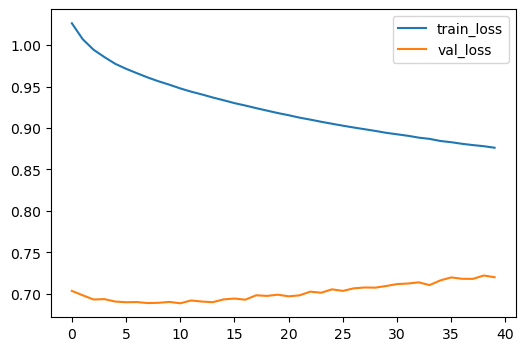

In [137]:
pre_test_predict=model.predict(test_data, verbose=1)
history=model.fit(train_data,train_label[:,:],epochs=40,batch_size=32,verbose=0,validation_data=(val_data,val_label[:,param]))

print("End validation loss is:", history.history['val_loss'][-1])
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

3/3 [==============================] - 0s 660us/step


Text(0.5, 1.0, 'Testing Data')

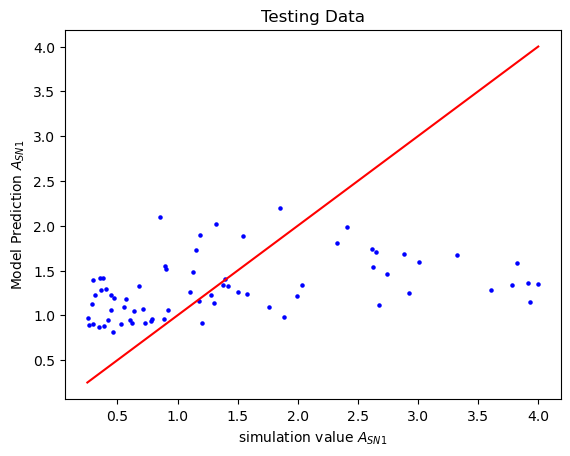

In [139]:
simpars = ['\Omega_m','\sigma_8','A_{SN1}','A_{AGN1}','A_{SN2}','A_{AGN2}']
lims = [[0.1,0.5],[0.6,1.0],[0.25,4.0],[0.25,4.0],[0.5,2.0],[0.5,2.0]]
param=2
test_predict=model.predict(test_data, verbose=1)
test_predict = test_predict[:,param]*std_labels[param] + mean_labels[param]
test_label_unorm = test_label[:,param]*std_labels[param] + mean_labels[param]
plt.plot(lims[param],lims[param],c='r')
plt.scatter(test_label_unorm, test_predict,s=5, color='blue')
# plt.ylim([np.min(test_label[:,param]),np.max(test_label[:,param])])
# plt.xlim([np.min(test_label[:,param]),np.max(test_label[:,param])])
plt.ylabel(f'Model Prediction ${simpars[param]}$')
plt.xlabel(f'simulation value ${simpars[param]}$')
plt.title('Testing Data')
# plt.axhline(0.5,c='k')

## $w_{\delta +}$/$w_{\delta \delta}$

In [167]:
wgplussesDM_z = []
wgcrossesDM_z = []
ggsDM_z = []
for i in range(0,700):
    for j, f in enumerate((f'../correlatingDM-folder/OUTPUT_CAMELS_DM_LH_z/wgp_LH{i}.dat',f'../correlatingDM-folder/OUTPUT_CAMELS_DM_LH_z/wgg_LH{i}.dat')):
        dat = ascii.read(f)
        if j == 0:
#             print(dat.colnames)
#             print(dat['meanr'])
            r, wgp, wgx = dat['rnom'], dat['wgplus'], dat['wgcross']
        elif j == 1:
            r, wgg = dat['rnom'], dat['wgg']
    
    wgplussesDM_z.append(wgp)
    wgcrossesDM_z.append(wgx)
    ggsDM_z.append(wgg)
    
label_table = np.loadtxt("CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt", skiprows=1, usecols=range(1, 7))
corr_labels = label_table[:700]
print(corr_labels.shape)

(700, 6)


In [168]:
corr_data = np.array(wgplussesDM_z)/np.array(ggsDM_z)

In [169]:
# shuffle
num_samples = corr_data.shape[0]
random_indices = np.random.permutation(num_samples)
corr_data = corr_data[random_indices]
corr_labels = corr_labels[random_indices]
# Normalise
mean_labels = np.mean(corr_labels,axis=0)
std_labels = np.std(corr_labels,axis=0)
print(mean_labels)
print(std_labels)
renorm_labels = (corr_labels-mean_labels) / (std_labels)  #+ 0.5 # mean of 0.5, std of 0.2

mean_corrs = np.mean(corr_data,axis=0)
std_corrs = np.std(corr_data,axis=0)
print(mean_corrs)
print(std_corrs)
renorm_corrs = (corr_data-mean_corrs)/(std_corrs)  # mean of 0, std of 0.2
# split
train_data, test_data, train_label, test_label = train_test_split(renorm_corrs, renorm_labels, test_size = 0.1, random_state = None, shuffle=True)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.05, random_state = None)
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)
print(val_data.shape, val_label.shape)

[0.29849143 0.80156743 1.34326033 1.3370337  1.09084681 1.08025094]
[0.11531638 0.11458019 1.03403915 1.01497173 0.43112156 0.42591877]
[ 0.03153533  0.02426508  0.0217947   0.01473189 -0.01149724 -0.0040306 ]
[0.02308655 0.02572781 0.03164752 0.3305937  1.02803669 0.39371883]
(598, 6) (598, 6)
(70, 6) (70, 6)
(32, 6) (32, 6)


#### Build Model

In [170]:
model = keras.models.Sequential()
#model.add(normalizer)
model.add(tf.keras.layers.Dense(128, input_shape=(6,), activation="relu"))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(64, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(64, activation='relu'))

# model.add(tf.keras.layers.BatchNormalization())  # Normalization 1
model.add(tf.keras.layers.Dense(8, activation='relu'))


# model.add(tf.keras.layers.BatchNormalization())  # Normalization 3
model.add(tf.keras.layers.Dense(1, activation='tanh'))
#model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.build()
model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_194 (Dense)           (None, 128)               896       
                                                                 
 dense_195 (Dense)           (None, 64)                8256      
                                                                 
 dense_196 (Dense)           (None, 64)                4160      
                                                                 
 dense_197 (Dense)           (None, 8)                 520       
                                                                 
 dense_198 (Dense)           (None, 1)                 9         
                                                                 
Total params: 13841 (54.07 KB)
Trainable params: 13841 (54.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


3/3 [==============================] - 0s 812us/step
End validation loss is: 0.9494207501411438


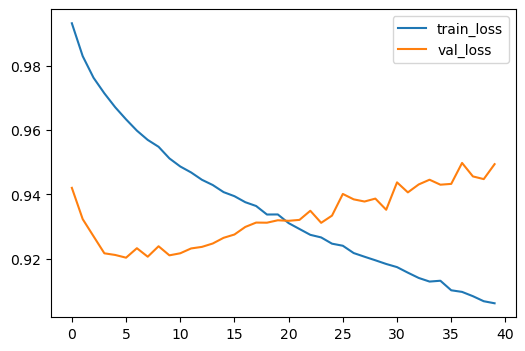

In [171]:
param =1
pre_test_predict=model.predict(test_data, verbose=1)
history=model.fit(train_data,train_label[:,param],epochs=40,batch_size=32,verbose=0,validation_data=(val_data,val_label[:,param]))

print("End validation loss is:", history.history['val_loss'][-1])
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

3/3 [==============================] - 0s 710us/step


Text(0.5, 1.0, 'Testing Data')

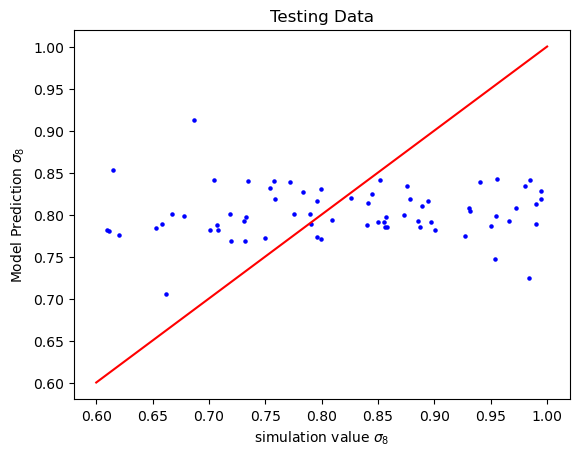

In [172]:
loss = model.evaluate(test_data, test_label[:, param], verbose=1)

simpars = ['\Omega_m','\sigma_8','A_{SN1}','A_{AGN1}','A_{SN2}','A_{AGN2}']
lims = [[0.1,0.5],[0.6,1.0],[0.25,4.0],[0.25,4.0],[0.5,2.0],[0.5,2.0]]
test_predict=model.predict(test_data, verbose=1)
test_predict = test_predict*std_labels[param] + mean_labels[param]
test_label_unorm = test_label[:,param]*std_labels[param] + mean_labels[param]
plt.plot(lims[param],lims[param],c='r')
plt.scatter(test_label_unorm, test_predict,s=5, color='blue')
# plt.ylim([np.min(test_label[:,param]),np.max(test_label[:,param])])
# plt.xlim([np.min(test_label[:,param]),np.max(test_label[:,param])])
plt.ylabel(f'Model Prediction ${simpars[param]}$')
plt.xlabel(f'simulation value ${simpars[param]}$')
plt.title('Testing Data')
# plt.axhline(0.5,c='k')

Text(0.5, 1.0, '$w_{\\delta +}$ dep on $\\sigma_8$')

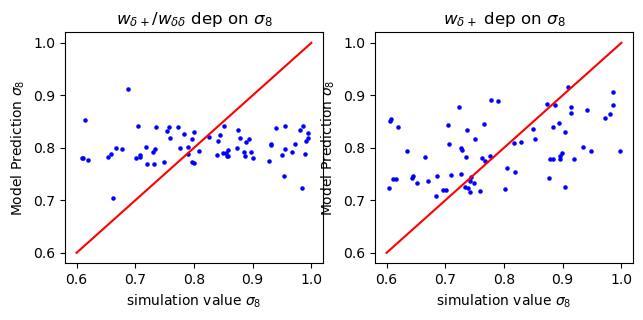

In [176]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(22/3,3))
ax[0].plot(lims[param],lims[param],c='r')
ax[0].scatter(test_label_unorm, test_predict,s=5, color='blue')
ax[0].set_ylabel(f'Model Prediction ${simpars[param]}$')
ax[0].set_xlabel(f'simulation value ${simpars[param]}$')
ax[0].set_title(r'$w_{\delta +}/w_{\delta \delta}$ dep on $\sigma_8$')

ax[1].plot(lims[param],lims[param],c='r')
ax[1].scatter(raw_sig8, raw_sig8_pred,s=5, color='blue')
ax[1].set_ylabel(f'Model Prediction ${simpars[param]}$')
ax[1].set_xlabel(f'simulation value ${simpars[param]}$')
ax[1].set_title(r'$w_{\delta +}$ dep on $\sigma_8$')


#### trying with PyTorch

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np


In [38]:
param=0
# Convert the data to PyTorch tensors
X_train = torch.tensor(train_data, dtype=torch.float32)
y_train = torch.tensor(train_label[:, param], dtype=torch.float32)

X_val = torch.tensor(val_data, dtype=torch.float32)
y_val = torch.tensor(val_label[:, param], dtype=torch.float32)

X_test = torch.tensor(test_data, dtype=torch.float32)
y_test = torch.tensor(test_label[:, param], dtype=torch.float32)


In [39]:
class LargerCorrelationModel(nn.Module):
    def __init__(self):
        super(LargerCorrelationModel, self).__init__()
        self.fc1 = nn.Linear(6, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)
        
        # Dropout layers to reduce overfitting
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = torch.relu(self.fc3(x))
        x = self.dropout(torch.relu(self.fc4(x)))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x


In [40]:
model = LargerCorrelationModel()
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.0005)


In [41]:
num_epochs = 200
best_val_loss = float('inf')
patience, patience_counter = 100, 0

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs.flatten(), y_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs.flatten(), y_val)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1
    
    if patience_counter > patience:
        print(f"Early stopping on epoch {epoch+1}")
        break

    # Print losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

Epoch [10/200], Loss: 0.9992, Val Loss: 1.0816
Epoch [20/200], Loss: 0.9951, Val Loss: 1.0890
Epoch [30/200], Loss: 0.9934, Val Loss: 1.0898
Epoch [40/200], Loss: 0.9921, Val Loss: 1.0883
Epoch [50/200], Loss: 0.9911, Val Loss: 1.0882
Epoch [60/200], Loss: 0.9856, Val Loss: 1.0891
Epoch [70/200], Loss: 0.9785, Val Loss: 1.0924
Epoch [80/200], Loss: 0.9711, Val Loss: 1.0972
Epoch [90/200], Loss: 0.9621, Val Loss: 1.1033
Epoch [100/200], Loss: 0.9542, Val Loss: 1.1021
Early stopping on epoch 106


In [42]:
# Load the best model based on validation loss
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs.flatten(), y_test)
    print(f'Test Loss: {test_loss.item():.4f}')


Test Loss: 1.0095


/var/folders/2k/4lvm79j14sg5_v8dqx8tly7h0000gn/T/ipykernel_33181/982689432.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.p

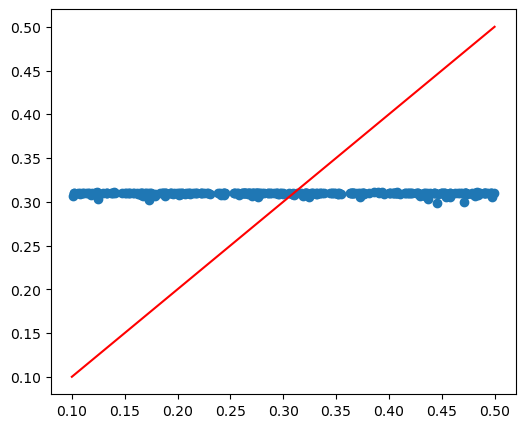

In [43]:
simpars = ['\Omega_m','\sigma_8','A_{SN1}','A_{SN2}','A_{AGN1}','A_{AGN2}']
lims = [[0.1,0.5],[0.6,1.0],np.log([0.25,4.0]),np.log([0.5,2.0]),np.log([0.5,2.0]),np.log([0.5,2.0])]


model_guess = model(X_test).flatten().detach().numpy() * std_labels[param] + mean_labels[param]
correct_labels = y_test * std_labels[param] + mean_labels[param]

plt.figure(figsize=(6,5))
plt.plot(lims[param],lims[param],c='r')
plt.scatter(correct_labels, model_guess)